In [3]:
import torch
import pandas as pd
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import gensim

INPUT_PATH = 'C:\\Users\\garvj\\Downloads\\NLP-HW2-main\\NLP-HW2-main\\yelp_academic_dataset_review.json'
DATASET_CSV_PATH = 'C:\\Users\\garvj\\Downloads\\NLP-HW2-main\\NLP-HW2-main\\yelp_reviews_gen.csv'
PATH_TO_YELP_REVIEWS = INPUT_PATH

device = torch.device("cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [4]:
with open(PATH_TO_YELP_REVIEWS, 'r', encoding='utf-8') as f:
  chunks = pd.read_json(f, lines=True, chunksize = 10000)
  for c_data in chunks:
    x = pd.DataFrame.from_dict(c_data)
    x.to_csv ('yelp_reviews_gen.csv',  mode='a', index=False, header=True)

In [4]:
top_data_df = pd.read_csv(DATASET_CSV_PATH)
print("Columns in the original dataset:\n")
print(top_data_df.columns)

Columns in the original dataset:

Index(['review_id', 'user_id', 'business_id', 'stars', 'useful', 'funny',
       'cool', 'text', 'date'],
      dtype='object')


Number of rows per star rating:
5        3231627
4        1452918
1        1069561
3         691934
2         544240
stars        699
Name: stars, dtype: int64


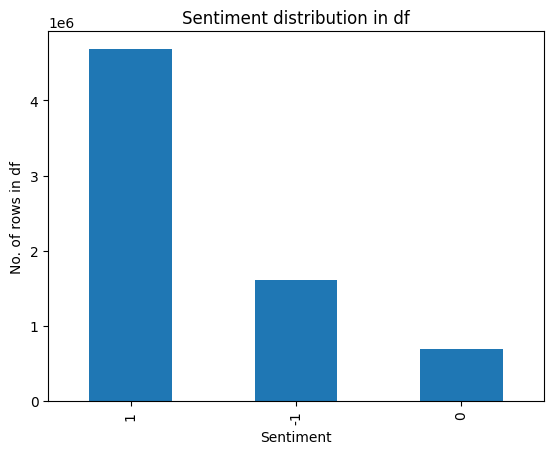

In [10]:
print("Number of rows per star rating:")
print(top_data_df['stars'].value_counts())

# Function to map stars to sentiment
def map_sentiment(stars_received):
    try:
        if int(stars_received) <= 2:
            return -1
        elif int(stars_received) == 3:
            return 0
        else:
            return 1
    except ValueError:
        return 1
# Mapping stars to sentiment into three categories
top_data_df['stars'].drop(index=top_data_df['stars'].index[0])
top_data_df['sentiment'] = [ map_sentiment(x) for x in top_data_df['stars']]
# Plotting the sentiment distribution
plt.figure()
pd.value_counts(top_data_df['sentiment']).plot.bar(title="Sentiment distribution in df")
plt.xlabel("Sentiment")
plt.ylabel("No. of rows in df")
plt.show()

In [11]:
# Function to retrieve top few number of each category
def get_top_data(top_n = 5000):
    top_data_df_positive = top_data_df[top_data_df['sentiment'] == 1].head(top_n)
    top_data_df_negative = top_data_df[top_data_df['sentiment'] == -1].head(top_n)
    top_data_df_neutral = top_data_df[top_data_df['sentiment'] == 0].head(top_n)
    top_data_df_small = pd.concat([top_data_df_positive, top_data_df_negative, top_data_df_neutral])
    return top_data_df_small

# Function call to get the top 10000 from each sentiment
top_data_df_small = get_top_data(top_n=10000)

# After selecting top few samples of each sentiment
print("After segregating and taking equal number of rows for each sentiment:")
print(top_data_df_small['sentiment'].value_counts())
top_data_df_small.head(10)

After segregating and taking equal number of rows for each sentiment:
 1    10000
-1    10000
 0    10000
Name: sentiment, dtype: int64


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,sentiment
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,1
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,1
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,1
6,6AxgBCNX_PNTOxmbRSwcKQ,r3zeYsv1XFBRA4dJpL78cw,gmjsEdUsKpj9Xxu6pdjH0g,5,0,2,0,Loved this tour! I grabbed a groupon and the p...,2015-01-03 23:21:18,1
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1
10,rGQRf8UafX7OTlMNN19I8A,1WHRWwQmZOZDAhp2Qyny4g,uMvVYRgGNXf5boolA9HXTw,5,2,0,0,My experience with Shalimar was nothing but wo...,2015-06-21 14:48:06,1
11,l3Wk_mvAog6XANIuGQ9C7Q,ZbqSHbgCjzVAqaa7NKWn5A,EQ-TZ2eeD_E0BHuvoaeG5Q,4,0,0,0,"Locals recommended Milktooth, and it's an amaz...",2015-08-19 14:31:45,1
12,XW_LfMv0fV21l9c6xQd_lw,9OAtfnWag-ajVxRbUTGIyg,lj-E32x9_FA7GmUrBGBEWg,4,0,0,0,Love going here for happy hour or dinner! Gre...,2014-06-27 22:44:01,1
13,8JFGBuHMoiNDyfcxuWNtrA,smOvOajNG0lS4Pq7d8g4JQ,RZtGWDLCAtuipwaZ-UfjmQ,4,0,0,0,Good food--loved the gnocchi with marinara\nth...,2009-10-14 19:57:14,1
14,UBp0zWyH60Hmw6Fsasei7w,4Uh27DgGzsp6PqrH913giQ,otQS34_MymijPTdNBoBdCw,4,0,2,0,The bun makes the Sonoran Dog. It's like a snu...,2011-10-27 17:12:05,1


In [12]:
# Removing the stop words
from gensim.parsing.preprocessing import remove_stopwords
print(remove_stopwords("Restaurant had a really good service!!"))

Restaurant good service!!


In [13]:
# Tokenize the text column to get the new column 'tokenized_text'
from gensim.utils import simple_preprocess
top_data_df_small['tokenized_text'] = [simple_preprocess(line, deacc=True) for line in top_data_df_small['text']] 
print(top_data_df_small['tokenized_text'].head(10))

1     [ve, taken, lot, of, spin, classes, over, the,...
3     [wow, yummy, different, delicious, our, favori...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [loved, this, tour, grabbed, groupon, and, the...
7     [amazingly, amazing, wings, and, homemade, ble...
10    [my, experience, with, shalimar, was, nothing,...
11    [locals, recommended, milktooth, and, it, an, ...
12    [love, going, here, for, happy, hour, or, dinn...
13    [good, food, loved, the, gnocchi, with, marina...
14    [the, bun, makes, the, sonoran, dog, it, like,...
Name: tokenized_text, dtype: object


In [14]:
from gensim.parsing.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Get the stemmed_tokens
top_data_df_small['stemmed_tokens'] = [[porter_stemmer.stem(word) for word in tokens] for tokens in top_data_df_small['tokenized_text'] ]
top_data_df_small['stemmed_tokens'].head(10)

1     [ve, taken, lot, of, spin, class, over, the, y...
3     [wow, yummi, differ, delici, our, favorit, is,...
4     [cute, interior, and, owner, gave, us, tour, o...
6     [love, thi, tour, grab, groupon, and, the, pri...
7     [amazingli, amaz, wing, and, homemad, bleu, ch...
10    [my, experi, with, shalimar, wa, noth, but, wo...
11    [local, recommend, milktooth, and, it, an, ama...
12    [love, go, here, for, happi, hour, or, dinner,...
13    [good, food, love, the, gnocchi, with, marinar...
14    [the, bun, make, the, sonoran, dog, it, like, ...
Name: stemmed_tokens, dtype: object

In [15]:
from sklearn.model_selection import train_test_split
# Train Test Split Function
def split_train_test(top_data_df_small, test_size=0.3, shuffle_state=True):
    X_train, X_test, Y_train, Y_test = train_test_split(top_data_df_small[['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id', 'stemmed_tokens']], 
                                                        top_data_df_small['sentiment'], 
                                                        shuffle=shuffle_state,
                                                        test_size=test_size, 
                                                        random_state=15)
    print("Value counts for Train sentiments")
    print(Y_train.value_counts())
    print("Value counts for Test sentiments")
    print(Y_test.value_counts())
    print(type(X_train))
    print(type(Y_train))
    X_train = X_train.reset_index()
    X_test = X_test.reset_index()
    Y_train = Y_train.to_frame()
    Y_train = Y_train.reset_index()
    Y_test = Y_test.to_frame()
    Y_test = Y_test.reset_index()
    print(X_train.head())
    return X_train, X_test, Y_train, Y_test

# Call the train_test_split
X_train, X_test, Y_train, Y_test = split_train_test(top_data_df_small)

Value counts for Train sentiments
 1    7036
-1    7008
 0    6956
Name: sentiment, dtype: int64
Value counts for Test sentiments
 0    3044
-1    2992
 1    2964
Name: sentiment, dtype: int64
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>
   index             business_id cool                 date funny  \
0  41968  h7zxeLAdUyAO6S6UzXJDwA    0  2018-05-20 02:15:46     0   
1  21239  ySXKjndttZjNy3kcqRqG3g    0  2015-12-20 20:30:12     0   
2  43746  9gObo5ltOMo6UgsaXaHPWA    0  2015-12-05 23:57:22     0   
3  35110  tvbFcYCEQWc76CUK-nBw8w    0  2018-07-27 08:09:21     0   
4   2960  Yv6HUVu7fRMnt_NtGdVQBw    0  2018-06-19 18:16:51     0   

                review_id stars  \
0  xkcYjM_5w9rdSiN8_Qz_Tg     1   
1  XIYnB19-LAI_yzJfB2d7eQ     3   
2  Nm2XaG0sQ7p3LHoZG44cAg     1   
3  L8Ape_IoEHiMjgiufwCp8Q     3   
4  0uD1hdeUNPyfAaGOKpMMeQ     5   

                                                text useful  \
0  Kids talking and being disruptive during the w.

In [18]:
from gensim.models import Word2Vec
size = 500
window = 3
min_count = 1
workers = 3
sg = 1
OUTPUT_FOLDER = 'C:\\Users\\garvj\\Downloads\\NLP-HW2-main\\NLP-HW2-main\\OpData'
# Function to train word2vec model
def make_word2vec_model(top_data_df_small, padding=True, sg=1, min_count=1, size=500, workers=3, window=3):
    if  padding:
        print(len(top_data_df_small))
        temp_df = pd.Series(top_data_df_small['stemmed_tokens']).values
        temp_df = list(temp_df)
        temp_df.append(['pad'])
        word2vec_file = OUTPUT_FOLDER + '\\models\\'+'word2vec_' + str(size) + '_PAD.model'
    else:
        temp_df = top_data_df_small['stemmed_tokens']
        word2vec_file = OUTPUT_FOLDER + '\\models\\' + 'word2vec_' + str(size) + '.model'
    w2v_model = Word2Vec(temp_df, min_count = min_count, vector_size=size, workers = workers, window = window, sg = sg)

    w2v_model.save(word2vec_file)
    return w2v_model, word2vec_file

# Train Word2vec model
w2vmodel, word2vec_file = make_word2vec_model(top_data_df_small, padding=True, sg=sg, min_count=min_count, size=size, workers=workers, window=window)

30000


In [19]:
max_sen_len = top_data_df_small.stemmed_tokens.map(len).max()
padding_idx = w2vmodel.wv.key_to_index['pad']
def make_word2vec_vector_cnn(sentence):
    padded_X = [padding_idx for i in range(max_sen_len)]
    i = 0
    for word in sentence:
        if word not in w2vmodel.wv.key_to_index:
            padded_X[i] = 0
            print(word)
        else:
            padded_X[i] = w2vmodel.wv.key_to_index[word]
        i += 1
    return torch.tensor(padded_X, dtype=torch.long, device=device).view(1, -1)

In [20]:
# Function to get the output tensor
def make_target(label):
    if label == -1:
        return torch.tensor([0], dtype=torch.long, device=device)
    elif label == 0:
        return torch.tensor([1], dtype=torch.long, device=device)
    else:
        return torch.tensor([2], dtype=torch.long, device=device)

In [22]:
EMBEDDING_SIZE = 500
NUM_FILTERS = 10

class CnnTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes, window_sizes=(1,2,3,5)):
        super(CnnTextClassifier, self).__init__()
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER + '\\models\\' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.key_to_index['pad'])
        # Without pretrained embeddings
        # self.embedding = nn.Embedding(vocab_size, EMBEDDING_SIZE)

        self.convs = nn.ModuleList([
                                   nn.Conv2d(1, NUM_FILTERS, [window_size, EMBEDDING_SIZE], padding=(window_size - 1, 0))
                                   for window_size in window_sizes
        ])

        self.fc = nn.Linear(NUM_FILTERS * len(window_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x) # [B, T, E]

        # Apply a convolution + max_pool layer for each window size
        x = torch.unsqueeze(x, 1)
        xs = []
        for conv in self.convs:
            x2 = torch.tanh(conv(x))
            x2 = torch.squeeze(x2, -1)
            x2 = F.max_pool1d(x2, x2.size(2))
            xs.append(x2)
        x = torch.cat(xs, 2)

        # FC
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        probs = F.softmax(logits, dim = 1)

        return probs

In [26]:
NUM_CLASSES = 3
vocab_len = len(w2vmodel.wv)

cnn_model = CnnTextClassifier(vocab_size=vocab_len, num_classes=NUM_CLASSES)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 2

# Open the file for writing loss
loss_file_name = OUTPUT_FOLDER +  '\\plots\\' + 'cnn_class_big_loss_with_padding.csv'
f = open(loss_file_name,'w')
f.write('iter, loss')
f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in X_train.iterrows():
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Epoch ran :"+ str(epoch+1))
    f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
    f.write('\n')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER +'\\' +'cnn_big_model_500_with_padding.pth')

f.close()
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1
Epoch ran :1
Epoch2
Epoch ran :2
Input vector
[[  297    43   236   171     0    32     2   173    47   341   790     1
  10123   108   275    62     2  1877   108   282     2   879    36   646
     31  2320  1649   196     1   254     3   201    53     0  1719   166
     31     0   201   989   247    15   263     1   504   466  1190     0
     44    22     0    74     7   219    30  6008  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113  1113
   1113  1113  1113  1113  1113  1113  1113  1113  1113  11

In [28]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

count_parameters(cnn_model)

+----------------+------------+
|    Modules     | Parameters |
+----------------+------------+
| convs.0.weight |    5000    |
|  convs.0.bias  |     10     |
| convs.1.weight |   10000    |
|  convs.1.bias  |     10     |
| convs.2.weight |   15000    |
|  convs.2.bias  |     10     |
| convs.3.weight |   25000    |
|  convs.3.bias  |     10     |
|   fc.weight    |    120     |
|    fc.bias     |     3      |
+----------------+------------+
Total Trainable Params: 55163


55163

Index(['iter', ' loss'], dtype='object')
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      2992
           1       0.66      0.55      0.60      3044
           2       0.70      0.85      0.77      2964

    accuracy                           0.71      9000
   macro avg       0.71      0.71      0.71      9000
weighted avg       0.71      0.71      0.71      9000

Index(['iter', ' loss'], dtype='object')


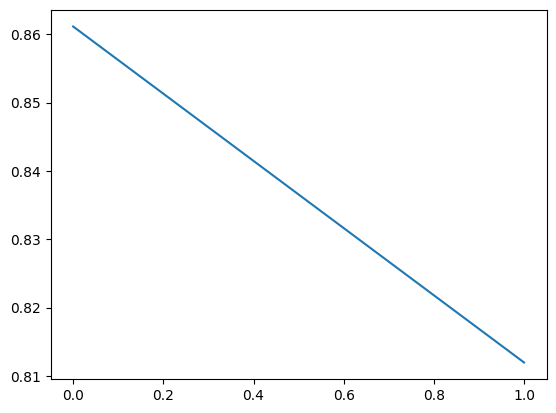

In [29]:
from sklearn.metrics import classification_report
bow_cnn_predictions = []
original_lables_cnn_bow = []
cnn_model.eval()
loss_df = pd.read_csv(OUTPUT_FOLDER + '\\plots\\'+'cnn_class_big_loss_with_padding.csv')
print(loss_df.columns)
# loss_df.plot('loss')
with torch.no_grad():
    for index, row in X_test.iterrows():
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
        probs = cnn_model(bow_vec)
        _, predicted = torch.max(probs.data, 1)
        bow_cnn_predictions.append(predicted.cpu().numpy()[0])
        original_lables_cnn_bow.append(make_target(Y_test['sentiment'][index]).cpu().numpy()[0])
print(classification_report(original_lables_cnn_bow,bow_cnn_predictions))
loss_file_name = OUTPUT_FOLDER +  '\\plots\\' + 'cnn_class_big_loss_with_padding.csv'
loss_df = pd.read_csv(loss_file_name)
print(loss_df.columns)
plt_500_padding_30_epochs = loss_df[' loss'].plot()
fig = plt_500_padding_30_epochs.get_figure()
fig.savefig(OUTPUT_FOLDER +'\\plots\\' + 'loss_plt_500_padding_30_epochs.pdf')


In [34]:
class SentimentLSTM(nn.Module):
    """
    The RNN model that will be used to perform Sentiment analysis.
    """

    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        """
        Initialize the model by setting up the layers.
        """
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        w2vmodel = gensim.models.KeyedVectors.load(OUTPUT_FOLDER+ '\\models\\' + 'word2vec_500_PAD.model')
        weights = w2vmodel.wv
        # With pretrained embeddings
        self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(weights.vectors), padding_idx=w2vmodel.wv.key_to_index['pad'])
        # embedding and LSTM layers
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        # dropout layer
        self.dropout = nn.Dropout(0.3)
        
        # linear and sigmoid layers
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        

    def forward(self, x, hidden):
        """
        Perform a forward pass of our model on some input and hidden state.
        """
        batch_size = x.size(0)

        # embeddings and lstm_out
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
    
        # stack up lstm outputs
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        # dropout and fully-connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)
        # sigmoid function
        sig_out = self.sig(out)
        
        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1] # get last batch of labels
        
        # return last sigmoid output and hidden state
        return sig_out, hidden
    
    
    def init_hidden(self, batch_size, train_on_gpu=True):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                      weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden

In [39]:
from tqdm import tqdm
NUM_CLASSES = 3
VOCAB_SIZE = len(w2vmodel.wv.index_to_key)

cnn_model = SentimentLSTM(vocab_size=VOCAB_SIZE, output_size=NUM_CLASSES, embedding_dim=EMBEDDING_SIZE, hidden_dim = 256, n_layers=2)
cnn_model.to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
num_epochs = 2


with open(OUTPUT_FOLDER+ '\\lstm\\'+ '\\plots\\'+'lstm_class_big_loss_with_padding.csv','w') as f:
    f.write('iter, loss')
    f.write('\n')
losses = []
cnn_model.train()
for epoch in range(num_epochs):
    print("Epoch" + str(epoch + 1))
    train_loss = 0
    for index, row in tqdm(X_train.iterrows(), total=len(X_train)):
        # Clearing the accumulated gradients
        cnn_model.zero_grad()

        # Make the bag of words vector for stemmed tokens 
        bow_vec = make_word2vec_vector_cnn(row['stemmed_tokens'])
       
        # Forward pass to get output
        probs = cnn_model(bow_vec)

        # Get the target label
        target = make_target(Y_train['sentiment'][index])

        # Calculate Loss: softmax --> cross entropy loss
        loss = loss_function(probs, target)
        train_loss += loss.item()

        # Getting gradients w.r.t. parameters
        loss.backward()

        # Updating parameters
        optimizer.step()


    # if index == 0:
    #     continue
    print("Score: " + str((epoch+1)) + "," + str(train_loss / len(X_train)))
    with open(OUTPUT_FOLDER+ '\\lstm\\'+ '\\plots\\'+'lstm_class_big_loss_with_padding.csv', 'a') as f:
        f.write(str((epoch+1)) + "," + str(train_loss / len(X_train)))
        f.write('\n')
    
    if epoch % 5 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': cnn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            }, OUTPUT_FOLDER+ '\\lstm\\'+ '\\ckpts\\'+ f'epoch_{epoch}.pt')
    train_loss = 0

torch.save(cnn_model, OUTPUT_FOLDER+ '\\lstm\\'+ 'lstm_big_model_500_with_padding.pth')
print("Input vector")
print(bow_vec.cpu().numpy())
print("Probs")
print(probs)
print(torch.argmax(probs, dim=1).cpu().numpy()[0])

Epoch1


  0%|          | 0/21000 [00:00<?, ?it/s]


TypeError: SentimentLSTM.forward() missing 1 required positional argument: 'hidden'